# Klasifikasi Citra Penyakit Radang Paru-Paru dan Paru Paru Terindikasi COVID19 Menggunakan Metode CNN

Link Kaggle : https://www.kaggle.com/prashant268/chest-xray-covid19-pneumonia

# Load Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/drive/MyDrive/Colab Notebooks/tubes"

In [ ]:
%cd "/content/drive/MyDrive/Colab Notebooks/tubes"

/content/drive/MyDrive/Colab Notebooks/tubes


In [ ]:
!ls

best_model2.h5	best_model.h5  Data  dataset  datasplit  kaggle.json


In [ ]:
#!kaggle datasets download -d prashant268/chest-xray-covid19-pneumonia

100% 2.05G/2.06G [00:21<00:00, 28.9MB/s]
100% 2.06G/2.06G [00:28<00:00, 76.5MB/s]


In [ ]:
#!unzip \*.zip &> /dev/null && rm *.zip

In [ ]:
#!mkdir covid

In [ ]:
#!mkdir normal

In [ ]:
#!mkdir pneumonia

In [ ]:
#!ls Data/

test  train


In [ ]:
#!mv Data/test/COVID19/*.jpg covid/

In [ ]:
#!mv Data/test/PNEUMONIA/*.jpg pneumonia/

In [ ]:
#!mv Data/test/NORMAL/*.jpg normal/

In [ ]:
#!mv Data/train/COVID19/*.jpg covid/

In [ ]:
#!mv Data/train/PNEUMONIA/*.jpg pneumonia/

In [ ]:
#!mv Data/train/NORMAL/*.jpg normal/

In [ ]:
#!ls

covid  Data  kaggle.json  normal  pneumonia


In [ ]:
#!mkdir dataset

In [ ]:
#!mv pneumonia covid normal dataset

In [ ]:
#!ls dataset

covid  normal  pneumonia


In [ ]:
#!mkdir datasplit

# Splitting Data 1 (Skenario = 0.7, 0.2, 0.1)

In [ ]:
#pip install split-folders

In [ ]:
data = "/content/drive/MyDrive/Colab Notebooks/tubes/dataset"
split = "/content/drive/MyDrive/Colab Notebooks/tubes/datasplit"

In [ ]:
#import splitfolders
#splitfolders.ratio(data, output=split, seed=1337, ratio=(.7,.2,.1),group_prefix=None)

In [ ]:
!ls datasplit

test  train  val


In [ ]:
train_path = "/content/drive/MyDrive/Colab Notebooks/tubes/datasplit/train"
val_path = "/content/drive/MyDrive/Colab Notebooks/tubes/datasplit/val"
test_path = "/content/drive/MyDrive/Colab Notebooks/tubes/datasplit/test"

# Preprocessing (Skenario 1)

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
from sklearn.utils import shuffle
Batch_size=32
augmen_gen = ImageDataGenerator(rescale=1. / 255,
                            rotation_range=40,
                            width_shift_range=0.2,
                            height_shift_range=0.2,
                            zoom_range=0.2,
                            horizontal_flip=True,
                            fill_mode='nearest')

train_gen = augmen_gen.flow_from_directory(
    train_path,
    class_mode = 'categorical',
    shuffle=False,
    target_size = (224,224),
    batch_size=Batch_size,
    color_mode ='rgb'
)

val_gen = augmen_gen.flow_from_directory(
    val_path,
    class_mode = 'categorical',
    shuffle=False,
    target_size = (224,224),
    batch_size=Batch_size,
    color_mode ='rgb'
)

test_gen = augmen_gen.flow_from_directory(
    test_path,
    class_mode = 'categorical',
    shuffle=False,
    target_size = (224,224),
    batch_size=Batch_size,
    color_mode ='rgb',
)

Found 4502 images belonging to 3 classes.
Found 1285 images belonging to 3 classes.
Found 645 images belonging to 3 classes.


# Modelling & Plotting (Skenario 5)

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, Dense, Conv2D, MaxPool2D, Flatten, AveragePooling2D, BatchNormalization, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.optimizers import Adam
import time

In [ ]:
model = Sequential()

model.add(InputLayer(input_shape=[224,224,3]))
model.add(Conv2D(filters=32, kernel_size=3, strides=1, padding='same', activation='relu'))
model.add(MaxPool2D(pool_size=2, padding='same'))
model.add(Conv2D(filters=64, kernel_size=3, strides=1, padding='same', activation='relu'))
model.add(MaxPool2D(pool_size=2, padding='same'))
model.add(Conv2D(filters=128, kernel_size=3, strides=1, padding='same', activation='relu'))
model.add(MaxPool2D(pool_size=2, padding='same'))
model.add(Dropout(0.25))
model.add(BatchNormalization())
model.add(Flatten())

# Fully Connected Layer
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(3, activation='softmax'))

In [ ]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 56, 56, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 28, 28, 128)      0

In [ ]:
best_model_path = 'best_model.h5'
checkpoint_callback = ModelCheckpoint(best_model_path,
                                     monitor='val_accuracy',
                                     save_best_only=True,
                                     verbose=1)
reduce_callback = ReduceLROnPlateau(monitor='val_accuracy', patience=3, factor=0.5, min_lr=0.000003, verbose=1)
callbacks_list = [checkpoint_callback, reduce_callback]

In [ ]:
model.compile(loss='categorical_crossentropy',
             optimizer=Adam(lr=0.00015),
             metrics='accuracy')

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
start = time.time()
H = model.fit_generator(train_gen, epochs=100,validation_data=val_gen, validation_steps = 4, verbose=1, callbacks=[callbacks_list])

End = time.time()
print ("training time: ", End-start,"s")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


Epoch 1/100
141/141 [==============================] - ETA: 0s - loss: 0.6832 - accuracy: 0.7568
Epoch 00001: val_accuracy improved from -inf to 0.87500, saving model to best_model.h5
141/141 [==============================] - 1169s 8s/step - loss: 0.6832 - accuracy: 0.7568 - val_loss: 0.8814 - val_accuracy: 0.8750 - lr: 1.5000e-04
Epoch 2/100
141/141 [==============================] - ETA: 0s - loss: 0.4096 - accuracy: 0.8287
Epoch 00002: val_accuracy did not improve from 0.87500
141/141 [==============================] - 223s 2s/step - loss: 0.4096 - accuracy: 0.8287 - val_loss: 0.8405 - val_accuracy: 0.6562 - lr: 1.5000e-04
Epoch 3/100
141/141 [==============================] - ETA: 0s - loss: 0.3719 - accuracy: 0.8474
Epoch 00003: val_accuracy did not improve from 0.87500
141/141 [==============================] - 207s 1s/step - loss: 0.3719 - accuracy: 0.8474 - val_loss: 0.6426 - val_accuracy: 0.7266 - lr: 1.5000e-04
Epoch 4/100
141/141 [==============================] - ETA: 0s -

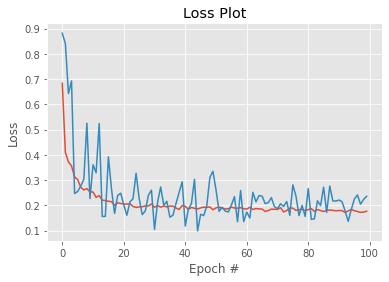

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

plt.style.use("ggplot")

plt.plot(np.arange(0, 100), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, 100), H.history["val_loss"], label="val_loss")
plt.title("Loss Plot")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.show()

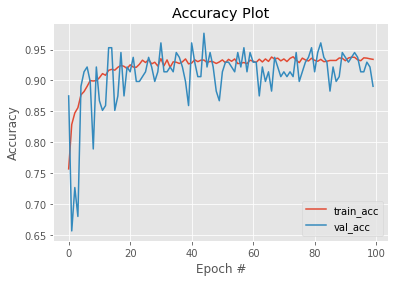

In [ ]:
plt.plot(np.arange(0, 100), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, 100), H.history["val_accuracy"], label="val_acc")
plt.title("Accuracy Plot")
plt.xlabel("Epoch #")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import classification_report

model.load_weights(best_model_path)
pred = model.predict(test_gen)
predictions = np.argmax(pred, axis = 1)
# labels = (pred > 0.5).astype(np.int)
print(classification_report(test_gen.classes,predictions))

              precision    recall  f1-score   support

           0       0.98      0.86      0.92        58
           1       0.90      0.84      0.87       159
           2       0.93      0.97      0.95       428

    accuracy                           0.93       645
   macro avg       0.94      0.89      0.91       645
weighted avg       0.93      0.93      0.93       645

